In [265]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pylab
import seaborn as sns

import datetime as dt

from scipy import stats

from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit

import pandas_profiling

In [6]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv.zip')
sales_train = pd.read_csv('sales_train.csv.zip',  parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32','item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
sample_submissions = pd.read_csv('sample_submission.csv.zip')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv.zip')

In [4]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [5]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [6]:
sales_train.head(8)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1
1,2013-03-01,0,25,2552,899.000000,1
2,2013-05-01,0,25,2552,899.000000,-1
3,2013-06-01,0,25,2554,1709.050049,1
4,2013-01-15,0,25,2555,1099.000000,1
5,2013-10-01,0,25,2564,349.000000,1
6,2013-02-01,0,25,2565,549.000000,1
7,2013-04-01,0,25,2572,239.000000,1


In [7]:
sample_submissions.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [8]:
shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [9]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


## Here we merge all tables related with the train data into one table

In [7]:
# merge data into one table
train = sales_train.join(items, on = 'item_id', rsuffix='_')\
                    .join(item_categories, on = 'item_category_id', rsuffix = '_')\
                    .join(shops, on = 'shop_id', rsuffix = '_')\
                    .drop(['item_id_', 'shop_id_', 'item_category_id_', 'item_name'], axis=1)

train['item_cnt_day'] = np.abs(train['item_cnt_day'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
0,2013-02-01,0,59,22154,999.000000,1,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-03-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-05-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-06-01,0,25,2554,1709.050049,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.000000,1,56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [49]:
profile = pandas_profiling.ProfileReport(train)
profile

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
profset = profile.description_set          #Extracting the info from the profile object
print(profset.keys())

dict_keys(['analysis', 'table', 'variables', 'scatter', 'correlations', 'missing', 'messages', 'package', 'sample', 'duplicates'])


In [51]:
attributes = profset["variables"]
print(attributes.keys())

dict_keys(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day', 'item_category_id', 'item_category_name', 'shop_name'])


In [56]:
shop_attributes = attributes['shop_name']
shop_attributes_keys = shop_attributes.keys()
shop_attributes_keys
shop_attributes

{'value_counts': index
 Москва ТЦ "Семеновский"                            235636
 Москва ТРК "Атриум"                                186104
 Химки ТЦ "Мега"                                    143480
 Москва ТЦ "МЕГА Теплый Стан" II                    142234
 Якутск Орджоникидзе, 56                            117428
 СПб ТК "Невский Центр"                             109253
 Москва ТЦ "МЕГА Белая Дача II"                     105366
 Воронеж (Плехановская, 13)                          82663
 Якутск ТЦ "Центральный"                             71441
 Чехов ТРЦ "Карнавал"                                69573
 Сергиев Посад ТЦ "7Я"                               66321
 Тюмень ТЦ "Гудвин"                                  65173
 Курск ТЦ "Пушкинский"                               63911
 Калуга ТРЦ "XXI век"                                59511
 Н.Новгород ТРЦ "Фантастика"                         58445
 Москва МТРЦ "Афи Молл"                              58133
 Воронеж ТРЦ "Максимир"          

In [132]:
# this graphic is constructed for demonstration of possibility to exctract attributes from data with help of pandas profiling
fig, axes = plt.subplots(figsize=(14, 10))

axes.xaxis.set_major_locator(ticker.MultipleLocator(1))

axes.yaxis.set_major_locator(ticker.MultipleLocator(50000))
axes.yaxis.set_minor_locator(ticker.MultipleLocator(10000))

# np.arange(1, shop_attributes['value_counts'].count() + 1, 1)
axes.plot(shop_attributes['value_counts'])
axes.set_title('Count of total sales per shop')
axes.grid(axis = 'x', color = 'green', linewidth = 1, linestyle = '--')

plt.xticks(rotation=90)
 
plt.tight_layout()

AttributeError: 'AxesSubplot' object has no attribute 'subplots'

## Split dates for more detailed exploration

In [11]:
train['date'] = pd.to_datetime(train['date'], format='%m.%Y')
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

train.head(4)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name,day,month,year
0,2013-02-01,0,59,22154,999.000000,1,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",1,2,2013
1,2013-03-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,3,2013
2,2013-05-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,5,2013
3,2013-06-01,0,25,2554,1709.050049,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,6,2013


## Check our data for missed values

In [19]:
train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_category_id      0
item_category_name    0
shop_name             0
day                   0
month                 0
year                  0
dtype: int64

## Group data by date, shop, item and category 

In [9]:
# group data by month
train_grouped_by_month = train[["date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id"]]\
.groupby(['date_block_num',"shop_id", "item_id", "item_category_id"])\
.agg({"item_price":"mean","item_cnt_day":"sum"}).reset_index()
train_grouped_by_month.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

train_grouped_by_month.head(8)

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month
0,0,0,32,40,221.0,6
1,0,0,33,37,347.0,3
2,0,0,35,40,247.0,1
3,0,0,43,40,221.0,1
4,0,0,51,57,128.5,2
5,0,0,61,43,195.0,1
6,0,0,75,40,76.0,1
7,0,0,88,40,76.0,1


## Sales count by shop_id and date graphic

In [131]:
#sales_date_shop = train[['shop_id', 'date_block_num', 'item_cnt_day']].groupby(['date_block_num', 'shop_id'])\
#.agg({'item_cnt_day': sum})
sales_date_shop = train_grouped_by_month.pivot_table(index=['shop_id'], values=['item_cnt_month'],\
                                    columns='date_block_num', aggfunc=np.sum)
#.pivot_table(index=['shop_id'], values=['item_cnt_day'], 
#                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()

#sales_date_shop.fillna(sales_date_shop.mean(), inplace=True)

fig = plt.figure(figsize=(13, 13)) 
ax = fig.add_subplot(111)
ax = sns.heatmap(sales_date_shop.reset_index(drop=True))
#plt.xlabel('Shops', fontsize = 15)
#plt.ylabel('Monthes', fontsize = 15)
ax.set_title('Sales count by shop_id and date graphic')
plt.tight_layout()

TypeError: 'Figure' object is not callable

In [82]:
most_popular_items = train_grouped_by_month.groupby('item_id').agg({"item_cnt_month":"sum"}).reset_index()
most_popular_items = most_popular_items.sort_values(by='item_cnt_month', ascending=False)
most_popular_items = most_popular_items.iloc[0:10].reset_index()
#most_popular_items_indexes = most_popular_items['index']
most_popular_items
#most_popular_items_indexes

,index,item_id,item_cnt_month
0,20602,20949,187678
1,2749,2808,17265
2,3654,3732,16710
3,17418,17717,15830
4,5717,5822,14529
5,3656,3734,11778
6,6543,6675,10341
7,3653,3731,10111
8,1814,1855,10050
9,16493,16787,9283


First item has the biggest total count of sales, so we can explorate this 

## Count histograms

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

axes[0].hist(train_grouped_by_month['item_cnt_month'])
axes[0].set_title('Count of items by month')

axes[1].hist(train_grouped_by_month.query('item_cnt_month > 750')['item_cnt_month'])
axes[1].set_title('Count of items which count is > 750')

axes[2].hist(np.log(1 + np.log(1 + np.log(1 + train_grouped_by_month['item_cnt_month']))))
axes[2].set_title('Count of items logarithmed three times')

fig    
plt.tight_layout()

AttributeError: 'AxesSubplot' object has no attribute 'subplots'

Here we can see that biggest part of count values belongs to [0,250], so we can explorate this interval separately

In [108]:
fig = plt.figure(figsize=(11, 5)) 
ax = fig.add_subplot(111)

sns.boxplot(x="item_cnt_month", data=train_grouped_by_month)
ax.set_title('Box plot')

plt.tight_layout()

TypeError: 'Figure' object is not callable

We can see that almost all values are clipped into [0, 750], so we can explorate this interval, interval from 750 to 1300, and outliers, separately

## Price histograms

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 5))

axes[0].hist(train_grouped_by_month['item_price'])
axes[0].set_title('Price histogram')

axes[1].hist(np.log(train_grouped_by_month['item_price']), bins=40)
axes[1].set_title('Logarithmed price histogram')

axes[2].hist(train_grouped_by_month.query('item_price > 45000 and item_price < 350000')['item_price'])
axes[2].set_title('Price histogram for values in [45000, 350000]')
fig    
plt.tight_layout()

AttributeError: 'AxesSubplot' object has no attribute 'subplots'

From this graphics we can see that almost all values belongs to [0, 25000] and between 75000 and 275000 there are no values. So we can explorate separetely groups [0, 25000] and [275000, 300000]

In [97]:
stats.probplot(np.log(train_grouped_by_month['item_price']), plot=plt)

((array([-4.92088874, -4.74440514, -4.64908479, ...,  4.64908479,
          4.74440514,  4.92088874]),
  array([-2.4079456, -2.4079456, -2.3644605, ..., 10.815409 , 10.839561 ,
         12.63779  ], dtype=float32)),
 (1.009043665803779, 6.071694374084473, 0.9781532892968127))

We can see that logarithmed data are very similar to normal distribution from -2 to 2 standart deviations. Also we can see huge offset for quantiles less -2 s.d., so it's have sense to explorate this separetely

AttributeError: 'AxesSubplot' object has no attribute 'show'

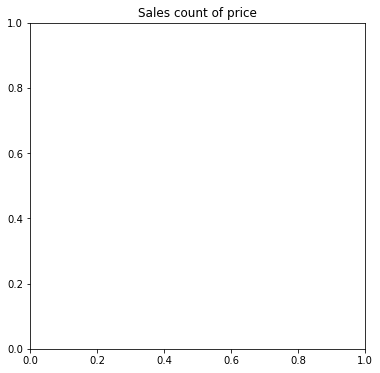

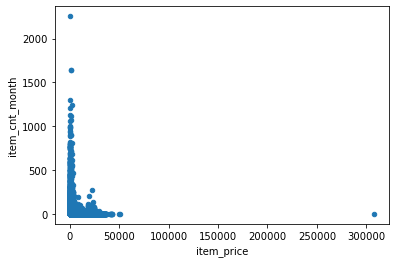

In [95]:
#train_grouped_by_month.plot.scatter(x='item_price', y='item_cnt_month').set_title('Sales count of price')

fig = plt.figure(figsize=(6, 6)) 
ax = fig.add_subplot(111)

plt = train_grouped_by_month.plot.scatter(x='item_price', y='item_cnt_month')
ax.set_title('Sales count of price')

plt.show()

<AxesSubplot:xlabel='item_price', ylabel='item_cnt_month'>

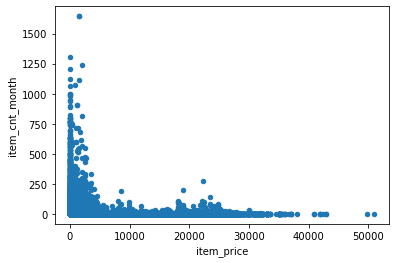

In [26]:
train_grouped_by_month.query('item_price < 300000 and item_cnt_month < 2000').plot.scatter(x='item_price', y='item_cnt_month')

Here we also see outliers for price values ~300000. Also we see that items with price [0,5000] have various sales counts (good idea is to split this group in some way). But price values >5000 have smaller various, except outliers. 

## Clip data into [0, 20]

In [274]:
train_grouped_by_month_clipped = train_grouped_by_month.copy()
train_grouped_by_month_clipped['logged_item_price'] = 2 + np.log(train_grouped_by_month_clipped['item_price'])
train_grouped_by_month_clipped['item_cnt_month'] = train_grouped_by_month['item_cnt_month'].clip(0., 20.)
train_grouped_by_month_clipped['item_cnt_month'].describe()

count    1.609124e+06
mean     2.031317e+00
std      2.581123e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_month, dtype: float64

## Clipped count of sales

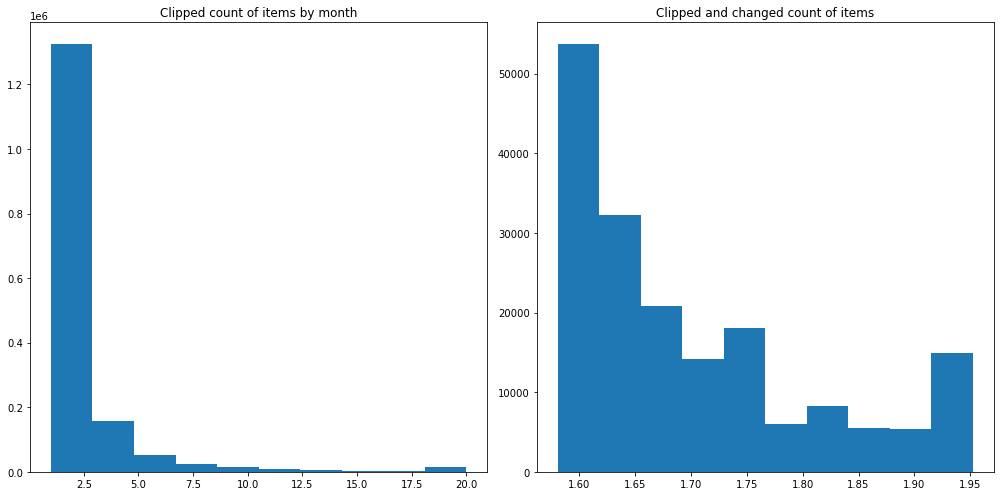

In [293]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

axes[0].hist(train_grouped_by_month_clipped['item_cnt_month'])
axes[0].set_title('Clipped count of items by month')

lmbda = 7.5
train_grouped_by_month_clipped['changed_item_cnt_month'] = \
                    np.exp(np.log(lmbda*train_grouped_by_month_clipped.query('item_cnt_month > 3')['item_cnt_month']+1)/lmbda)

axes[1].hist(train_grouped_by_month_clipped['changed_item_cnt_month'])
axes[1].set_title('Clipped and changed count of items')

fig    
plt.tight_layout()

We see that count of sales for value 20 is so big, because values more than 20 belongs to this after clipping. We can explorate group for values 20 separately

## Box-plot for clipped count of sales

Text(0.5, 1.0, 'Box plot for clipped count of sales')

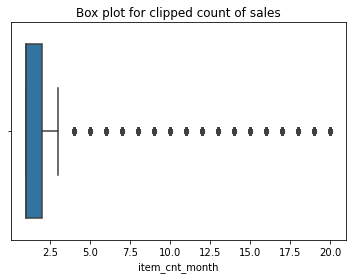

In [276]:
sns.boxplot(x="item_cnt_month", data=train_grouped_by_month_clipped).set_title('Box plot for clipped count of sales')

Text(0.5, 1.0, 'Box plot for clipped count of sales > 3')

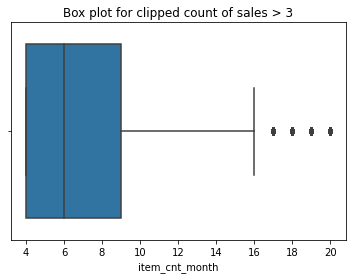

In [277]:
sns.boxplot(x="item_cnt_month", data=train_grouped_by_month_clipped.query('item_cnt_month > 3'))\
            .set_title('Box plot for clipped count of sales > 3')

We see that almost all values are in the [0, 3]. So we can explorate this values separetely

Text(0.5, 1.0, 'Clipped sales count of changed price')

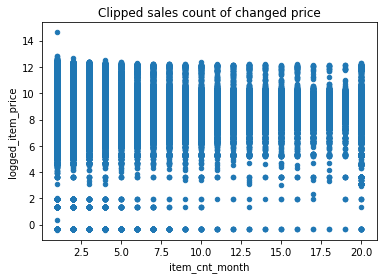

In [262]:
train_grouped_by_month_clipped.plot.scatter(x='item_cnt_month', y='logged_item_price')\
                            .set_title('Clipped sales count of changed price')
# TODO: box-plots

Lowest quantile is increasing except 20

## Outdated shops

In [328]:
sales_by_shop_id = sales_train.pivot_table(index=['shop_id'], values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()

sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(34):
    print('Shop is outdated for month', i, \
          sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1) == 0].unique())

Shop is outdated for month 0 []
Shop is outdated for month 1 []
Shop is outdated for month 2 [0 1]
Shop is outdated for month 3 [0 1]
Shop is outdated for month 4 [ 0  1  8 23]
Shop is outdated for month 5 [ 0  1  8 23]
Shop is outdated for month 6 [ 0  1  8 23]
Shop is outdated for month 7 [ 0  1  8 23 32]
Shop is outdated for month 8 [ 0  1  8 23 32]
Shop is outdated for month 9 [ 0  1  8 23 32]
Shop is outdated for month 10 [ 0  1  8 23 32]
Shop is outdated for month 11 [ 0  1  8 23 32]
Shop is outdated for month 12 [ 0  1  8 23 32]
Shop is outdated for month 13 [ 0  1  8 23 32]
Shop is outdated for month 14 [ 0  1  8 23 32]
Shop is outdated for month 15 [ 0  1  8 23 32]
Shop is outdated for month 16 [ 0  1  8 23 32]
Shop is outdated for month 17 [ 0  1  8 23 32]
Shop is outdated for month 18 [ 0  1  8 23 32]
Shop is outdated for month 19 [ 0  1  8 23 32]
Shop is outdated for month 20 [ 0  1  8 13 23 32]
Shop is outdated for month 21 [ 0  1  8 13 23 32]
Shop is outdated for month 22

Shops with id 0, 1, 8, 11, 13, 17, 23, 29, 30, 32, 33, 40, 43, 54 are closed. So we can keep them into array and predict for them zeros.

## Outdated items

In [117]:
sales_by_item_id = sales_train.pivot_table(index=['item_id'], values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()

sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'shop_id'

outdated_items_by_date = \
        {i: sales_by_item_id['shop_id'][sales_by_item_id.loc[:,str(i):].sum(axis=1) == 0].unique() for i in range(34)}


for i in range(34):
    print('Item is outdated for month', i, outdated_items_by_date[i])

Item is outdated for month 0 [ 4591  7547  8515 13477]
Item is outdated for month 1 [   19    50   215   591   631   637   648   708   807   808   813   824
   828   834  1068  1106  1136  1210  1213  1234  1265  1267  1277  1316
  1345  1605  1606  1616  1649  1661  1697  1870  1902  1909  1928  1947
  1979  1980  2055  2064  2112  2188  2200  2203  2479  2542  2554  2618
  2619  2636  2653  2684  2740  2762  2805  3189  3275  3390  3608  3628
  3667  3668  3680  3752  3766  3808  3810  3824  3883  3922  3948  3995
  3999  4010  4065  4096  4119  4154  4269  4278  4324  4506  4527  4591
  4592  4687  4815  4882  4922  4985  5016  5073  5201  5226  5278  5313
  5334  5345  5348  5360  5430  5537  5549  5566  5606  5771  5775  5886
  5970  5972  6096  6103  6178  6179  6201  6210  6230  6251  6262  6273
  6287  6325  6341  6469  6486  6610  6749  6783  6842  6884  6897  6924
  7080  7163  7200  7277  7282  7329  7357  7361  7370  7395  7443  7469
  7494  7509  7537  7547  7559  7560  75

There are many outdated items, so we can write algorithm, which takes items that are outdated for 3 (for example) last monthes and predict for them zero, independetly on it's shop_id

Text(0.5, 1.0, 'Count of outdated items by date')

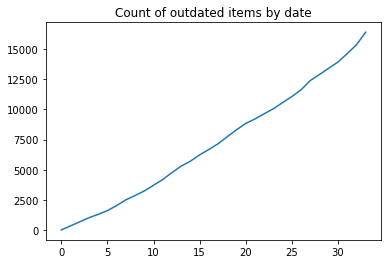

In [129]:
outdated_items_count_by_date = pd.Series({i: len(outdated_items_by_date[i]) for i in range(34)})
outdated_items_count_by_date.plot().set_title('Count of outdated items by date')

## Function for obtaining regression line for Series

In [136]:
def get_regression_line(data: pd.Series) -> pd.Series:
    size = data.size
    x = pd.Series(range(size))
    
    mean_x = x.mean()
    sigma_x = x.std()
    
    mean_y = data.mean()
    sigma_y = data.std()
    
    corr_coef = np.corrcoef(x, data)[0][1]
    
    regression_line = pd.Series(mean_y + corr_coef * sigma_y / sigma_x * (x - mean_x))
    
    return regression_line

## From this graphic we can obtain that sales have huge values on december

Text(0.5, 1.0, 'Count of sales by date')

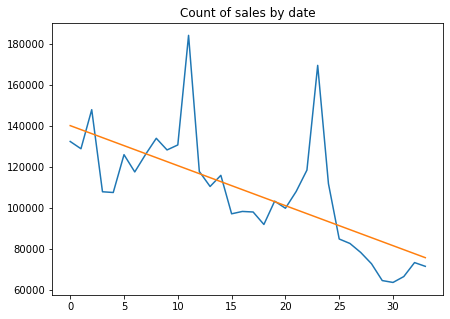

In [137]:
sales_by_date = train_grouped_by_month.groupby(['date_block_num'])['item_cnt_month'].sum()
regression_line_count = get_regression_line(sales_by_date)

fig = plt.figure(figsize=(7,5)) 
ax = fig.add_subplot(111)
ax.plot(pd.Series(range(34)), sales_by_date, pd.Series(range(34)), regression_line_count)
ax.set_title('Count of sales by date')

We can see that sales are decreasing, so it have sense to delete trend here. 

## Here we delete trend for count of sales

Text(0.5, 1.0, 'Count of sales without trend')

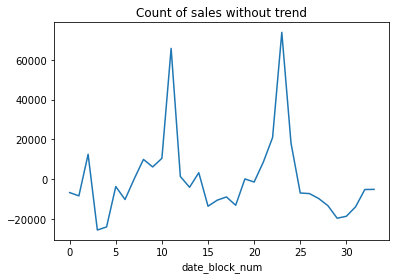

In [85]:
sales_without_trend = sales_by_date - regression_line_count
sales_without_trend.plot().set_title('Count of sales without trend')

We can notice cycles at this graphic, so it's have sense to group data by monthes and delete seasonality

## Average sales count per month

Text(0.5, 1.0, 'Mean count of sales without trend by month')

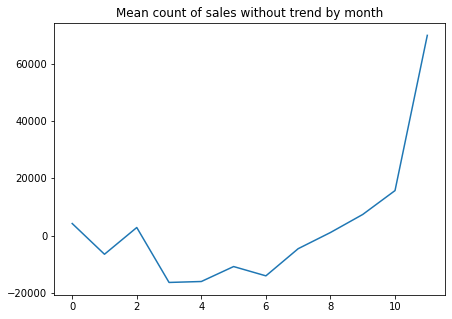

In [202]:
sales_count_by_month = np.zeros(12)

# Aggregate all count sales
sales_without_trend = sales_without_trend.to_numpy()
sales_count_by_month += (sales_without_trend[:12] + sales_without_trend[12:24])
# Last 3 monthes are not in our date period
sales_count_by_month += np.concatenate([sales_without_trend[24:33], np.zeros(3)])
    
# Some monthes occurs 3 times, another - 2 times
count_of_monthes = np.concatenate([np.full(9, 3), np.full(3, 2)])
sales_count_by_month /= count_of_monthes
    
fig = plt.figure(figsize=(7, 5)) 
ax = fig.add_subplot(111)
ax.plot(np.arange(0, 12, 1), sales_count_by_month)
ax.set_title('Mean count of sales without trend by month')

We see huge sales by decembers, increasing sales count from 6 month to 11, stagnation from 3 month to 6 and the standart sales from 0 to 2 month

## Total price by date

Text(0.5, 1.0, 'Total price for date')

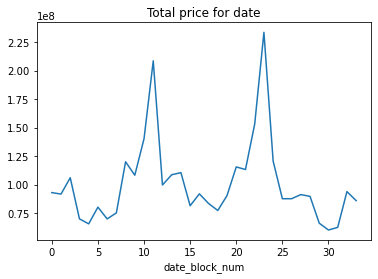

In [38]:
train_grouped_by_month['total_price'] = train_grouped_by_month['item_price'] * train_grouped_by_month['item_cnt_month']
sales_price_by_date = train_grouped_by_month.groupby(['date_block_num'])['total_price'].sum()
sales_price_by_date.plot().set_title('Total price for date')

## Mean total price per monthes

We can see here cycles, so we need to group data by monthes

Text(0.5, 1.0, 'Mean count of sales without trend by month')

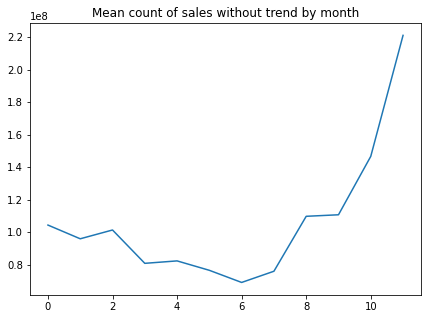

In [203]:
sales_price_by_month = np.zeros(12)

# Aggregate all count sales
sales_price_by_date = sales_price_by_date.to_numpy()
sales_price_by_month += (sales_price_by_date[:12] + sales_price_by_date[12:24])
# Last 3 monthes are not in our date period
sales_price_by_month += np.concatenate([sales_price_by_date[24:33], np.zeros(3)])
    
# Some monthes occurs 3 times, another - 2 times
count_of_monthes = np.concatenate([np.full(9, 3), np.full(3, 2)])
sales_price_by_month /= count_of_monthes
    
fig = plt.figure(figsize=(7, 5)) 
ax = fig.add_subplot(111)
ax.plot(np.arange(0, 12, 1), sales_price_by_month)
ax.set_title('Mean count of sales without trend by month')

This graphic is very similar to the same count graphic

## Number of items per category

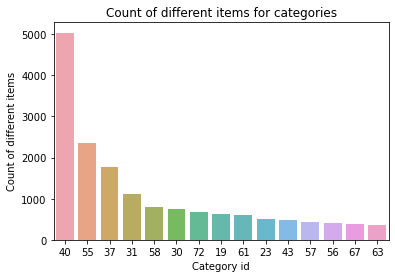

In [42]:
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id', ascending=False)
x=x.iloc[0:15].reset_index()
x['item_category_id'] = x['item_category_id'].astype(str)
#x=x.reset_index()

ax= sns.barplot(x=x.item_category_id, y=x.item_id, alpha=0.85)

ax.set_title('Count of different items for categories')
ax.set_xlabel('Category id')
ax.set_ylabel('Count of different items')

plt.show()
# TODO: sort by amount, not categories

We see that category №40 has more different items, so we can split it into bins in future

## Obviously sales are decreaing

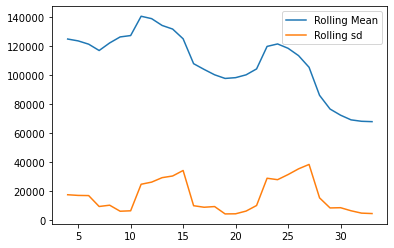

In [43]:
# rolling mean and standart deviation
plt.plot(sales_by_date.rolling(window=5,center=False).mean(),label='Rolling Mean');
plt.plot(sales_by_date.rolling(window=5,center=False).std(),label='Rolling sd');
plt.legend();

We see that rolling mean and standart deviation are also increased for decembers

## Class which adds/deletes features to data

In [277]:
# TODO: some shops/items become outdated. Deal with it
def get_regression_line_coefficients(data, groupby_fields, agg_field):
    
    data = data.groupby(groupby_fields).agg({agg_field: ['mean']})
    
    changed_data = data[agg_field]
    
    size = changed_data.size
    x = pd.Series(range(size))
    
    mean_x = x.mean()
    sigma_x = x.std()
    
    mean_y = changed_data.mean()
    sigma_y = changed_data.std()
    
    corr_coef = np.corrcoef(x, changed_data)[0][1]
    
    regression_line = pd.Series(mean_y + corr_coef * sigma_y / sigma_x * (x - mean_x))
    
    regression_line_with_val_month = pd.Series(np.zeros(size + 1))
    
    for i in range(size):
        regression_line_with_val_month[i] = regression_line_with[i]
        
    # prediction for one future validation month
    regression_line_with_val_month[size] = mean_y + corr_coef * sigma_y / sigma_x * (size - mean_x)
    
    return regression_line_with_val_month

In [275]:
# We need to build transformation from [shop_id, item_id] to some aggregated statistics
# It's been decided to use regression line
class FeatureEngineering:
    def __init__(self):
        # define regression line coefficients
        self.reg_line_1 = None
        self.reg_line_2 = None
        self.reg_line_3 = None
        
    # accepts train and validation sets and adds new features to them
    def transform(self, X):
        # TODO: Change merging series to dataframe
        X = pd.merge(X, self.reg_line_1, on=['shop_id', 'date_block_num'], how='left')
        X = pd.merge(X, self.reg_line_2, on=['item_id', 'date_block_num'], how='left')
        X = pd.merge(X, self.reg_line_3, on=['shop_id', 'item_id', 'date_block_num'], how='left')
        
        knn_features = ['shop_mean', 'shop_item_mean', 'item_mean']
        X = X[knn_features]

        return X
    
    # accepts only train set
    def fit(self, X):
        # TODO: add lag-features
        self.reg_line_1 = get_regression_line_coefficients(X, ['date_block_num', 'shop_id'], 'item_cnt_month')
        self.reg_line_2 = get_regression_line_coefficients(X, ['date_block_num', 'item_id'], 'item_cnt_month')
        self.reg_line_3 = get_regression_line_coefficients(X, ['date_block_num', 'shop_id', 'item_id'], 'item_cnt_month')
        
        return X

In [281]:
tdata = train_grouped_by_month.groupby(['shop_id', 'date_block_num']).agg({'item_cnt_month': ['mean']})
tdata['item_cnt_month']

mean
shop_id date_block_num          
0       0               2.338784
        1               2.515189
1       0               1.919870
        1               1.925587
2       0               1.587912
...                          ...
59      29              1.681400
        30              1.698816
        31              2.053963
        32              1.865580
        33              1.588000

[1586 rows x 1 columns]

## CV splitter

In [294]:
# inheritance
class CV_splitter():
    def __init__(self, first_month = 23, last_month = 33):
        self.first_month = first_month
        self.last_month = last_month

    def split(self, X, y, groups = None):
        for index in range(self.first_month, self.last_month + 1):
            
            X_train_ind = np.where(X['date_block_num'] < index)[0]
            X_val_ind = np.where(X['date_block_num'] == index)[0]
            
            yield X_train_ind, X_val_ind

In [261]:
clf = Pipeline([
    ( 'data_transformation', FeatureEngineering() ),
    ( 'standart_scaler', StandardScaler() ), 
    ( 'knn', KNeighborsRegressor() )
])

## Create splitter object and transfer it into GridSearchCV

In [291]:
params = {
    'n_neighbors': range(4, 9, 2), 
    'leaf_size': range(10, 17, 2), 
    'n_jobs': [-1]
}

#cv = CV_splitter(23, 34)

#grid_search = GridSearchCV(estimator = clf, param_grid = params, scoring = mean_squared_error, cv = cv)

In [268]:
X = train_grouped_by_month.copy()
y = train_grouped_by_month['item_cnt_month'].astype(int)

#grid_search.fit(X, y)
#best_model = grid_search.best_estimator_

In [298]:
def get_test_score_nested_cv(estimator, X, y, month_num, scoring):
    test_set_ind = np.where(X['date_block_num'] == month_num)[0]
    test_set_X = X[test_set_ind]
    test_set_y = y[test_set_ind]
    
    test_set_X = estimator.transform(test_set_X)
    pred_result = estimator.predict(test_set_X)
    
    res_score = scoring(test_set_y, pred_result)
    
    return res_score

In [295]:
# explorate possibility to use split when we always use previous 12 monthes
global_splits_count = 11

Cv_splitters = [CV_splitter(22, 23 + i) for i in range(global_splits_count)]
grid_searches = [GridSearchCV(estimator = clf, param_grid = params, scoring = mean_squared_error, cv = Cv_splitters[i]) \
                 for i in range(global_splits_count)]

errors = []

for i in range(global_splits_count):
    grid_searches[i].fit(X, y)
    error = get_test_score_nested_cv(grid_searches[i].best_estimator_, X, y, 24 + i, mean_squared_error)
    
    errors.append(error)

In [311]:
# obtain common statistics and best result
errors = np.array(errors)

# calculate rmse
errors = np.sqrt(errors)
np.mean(errors, axis=0)

1.1684270426517378

In [ ]:
# obtain the best score
max_value = np.max(errors)

conditon = (errors == max_value)
max_index = np.where(conditon)[0][0]

errors[max_index]

##  Selection the best model and extracting scores for all folds partitions

In [249]:
# select errors for best estimator
scores = []
mean_score: float

for tp in grid_search.grid_scores_:
    if tp.parameters == grid_search.best_params:
        scores = np.array(tp.cv_validation_scores)
        mean_score = mean_validation_score
        break
        
#scores = np.array([1 / (i + 1) for i in range(12)])
n = len(scores)

## Obtain best score without weightening

In [ ]:
max_value = np.max(scores)

conditon = (scores == max_value)
max_index = np.where(conditon)[0][0]

# the best score
scores[max_index]

## Calculate best weighted score

In [217]:
w = 1.5

weights = [w ** deg for deg in range(n - 1)]
# we need to give bigger weight to the "first" month
weights.insert(0, 1 + w ** (n - 1))
weights = np.array(weights)
# sum of weights is equal to (1 + w ** (n - 1)) + (w ** (n - 1) - 1), so total sum is equals to w ** n
assert w != 1
weights /= (w ** n)
weights

array([0.67437401, 0.00770735, 0.01156102, 0.01734153, 0.02601229,
       0.03901844, 0.05852766, 0.0877915 , 0.13168724, 0.19753086,
       0.2962963 , 0.44444444])

In [218]:
weighted_scores = scores * weights

max_value = np.max(weighted_scores)

conditon = (weighted_scores == max_value)
max_index = np.where(conditon)[0][0]

11

In [220]:
weighted_error = np.sum(weighted_scores)
weighted_error

0.24909535437444463

## Transform test set

In [37]:
def change_test_set(train, test):
    #train = train.query('date_block_num > 30')
    
    gp_shop_mean = train.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
    gp_shop_mean.columns = ['shop_mean']
    gp_shop_mean.reset_index(inplace=True)

    gp_item_mean = train.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
    gp_item_mean.columns = ['item_mean']
    gp_item_mean.reset_index(inplace=True)

    gp_shop_item_mean = train.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
    gp_shop_item_mean.columns = ['shop_item_mean']
    gp_shop_item_mean.reset_index(inplace=True)
    
    test_upd = test.copy()
    test_upd = pd.merge(test_upd, gp_shop_mean, on=['shop_id'], how='left')
    test_upd = pd.merge(test_upd, gp_item_mean, on=['item_id'], how='left')
    test_upd = pd.merge(test_upd, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
    
    knn_features = ['shop_mean', 'shop_item_mean', 'item_mean']
    knn_test = test_upd[knn_features]

    knn_test.fillna(knn_test.mean(), inplace=True)
    
    return knn_test

In [38]:
def get_result_test(test, best_model, best_scaler):
    knn_test = best_scaler.transform(test)
    knn_test_pred = best_model.predict(knn_test)
    
    return knn_test_pred

In [39]:
knn_test = change_test_set(train_grouped_by_month, test)
final_result = get_result_test(knn_test, best_model, best_scaler)
#final_result = final_results.rename(columns={0:'item_cnt_month'}, inplace=True)
final_result

C:\Users\Yauheni_Minau\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


array([1.88888889, 1.66666667, 1.55555556, ..., 1.88888889, 1.88888889,
       2.        ])

In [40]:
ans_test = test.copy()
ans_test['item_cnt_month'] = final_result
ans_test = ans_test.drop(['item_id', 'shop_id'], axis=1)
ans_test.reset_index(drop=True)
ans_test

,ID,item_cnt_month
0,0,1.888889
1,1,1.666667
2,2,1.555556
3,3,1.000000
4,4,1.666667
...,...,...
214195,214195,1.000000
214196,214196,1.888889
214197,214197,1.888889
214198,214198,1.888889


In [41]:
ans_test.to_csv('bad_result.csv')